<a href="https://colab.research.google.com/github/Sagar401/Natural_Language_Processing/blob/master/EAI6000_GroupProject_FinalReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team: Sagar Daswani and Pimchanok Khaoputhai**
# **EAI6000 - Foundations of AI**

# Final Project

# **Real or Not? Binary Classification of Disaster Tweets**
Kaggle Competition

Nowadays, social media has become a part of our daily life. People are sharing their experience and communicate to the public through platform like Facebook and Twitter. Sometimes, these channels are used for sharing emergency matters and news. However, the problem relies on whether the message is real. If yes, then monitoring these posts will help increase people awareness in time of emergency. As a result, this project is focusing on detecting if a post on Twitter about a disaster is a real event. 

The dataset is callled *Real or Not? NLP with Disaster Tweet* downloaded from Kaggle as a csv file. There are 7613 rows with 5 columns in training set and 3263 rows with 4 columns in testing set. The features are id, keyword, location, text, and target. Target is the label for each sample indicating if the tweet is a real disaster tweet (1) and otherwise (0)


The flow of the project are as follows:

*   Text cleaning
    * Remove special characters
    * Remove emoji
    * Spelling correction. We have written a code to perform correction but it is time consuming therefore we do not run the code and leave it as an option to do in the future.
*   Text preprocessing
    * Transform text into proper format to use in the models :
      * Vectorization, one hot coding
      * Word Embedding
*   Modeling
    * Linear Model
    * Recurrent Neural Network
        * LSTM

**Work to date**

As of March 24, 2020, we have discovered that word embedding works better than word vectoization. We also found a pre-trained embedding, GloVe developed by Standford. We are exploring the two different word embedding model one from keras and one from Glove. We built different models focusing more on RNN with different architecture. Below is the model development progress. We tried different model architecture to see which one gives more accuracy.

- Logistic Regression = 0.59
- RNN from scratch = 0.72
- RNN LSTM increase dimensionality with GloVe = 0.53
- RNN LSTM reduce dimensionality with GloVe = 0.78
- RNN LSTM stack layer with GloVe = 0.76
- RNN LSTM = 0.72

For each model we only run 10 epochs as it is time consuming. Previously, we run 10 epochs for our baseline model which is NN with embeded features but it seems to overfit. Hence, the later model are built with some regularization to deal with overfitting. We build RNN LSTM successively with different architecture from expanding dimension to reducing and stacking to see which would work best.

**Future Scope**
- Stick to only a few models then play with hyper parameters to see if tuning help increase the accuracy more than chaning the architecture

In [0]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
import re
import string
import nltk
from nltk.corpus import stopwords

# sklearn 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, train_test_split, cross_validate

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, GlobalAveragePooling1D, Bidirectional, Dropout
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
  

Using TensorFlow backend.


## **Import Dataset**

### Set up Kaggle API

In [0]:
! pip install -q kaggle
! mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"khaophuthaipkt","key":"742f0323b5693f569538176eceaa4d80"}
with open("/content/.kaggle/kaggle.json", "w") as file:
    json.dump(token, file)

! cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
! kaggle config set -n path -v content
! chmod 600 ~/.kaggle/kaggle.json

- path is now set to: content


In [0]:
! kaggle competitions download -c nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


### Import the data

In [0]:
train_df = pd.read_csv("/content/content/competitions/nlp-getting-started/train.csv")
test_df = pd.read_csv("/content/content/competitions/nlp-getting-started/test.csv")

In [0]:
#Looking at first few rows of dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## **Data Exploration and visualization**

In [0]:
print("Training Dataset Size:",train_df.shape)
print("Test Dataset Size:",test_df.shape)

Training Dataset Size: (7613, 5)
Test Dataset Size: (3263, 4)


In [0]:
#function to plot bar graph

def plot_bar(x):
  sns.barplot(x.index,x)
  plt.gca().set_ylabel('samples')

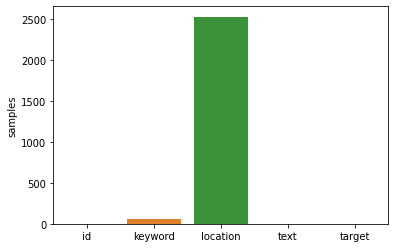

In [0]:
#missing values in training dataset
x = train_df.isnull().sum()
plot_bar(x)

There are a lot of missing value in location column. However, as we are focusing on text, we would say there is no missing value as text and target has no missing value

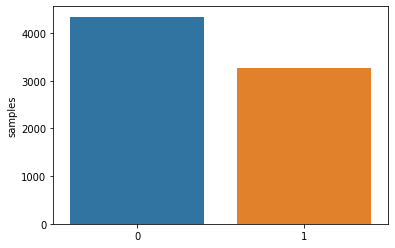

In [0]:
##let's check the class distribution
x = train_df['target'].value_counts()
plot_bar(x)

The distribution between two classes are not perfectly balanced, but it is still practical to use.

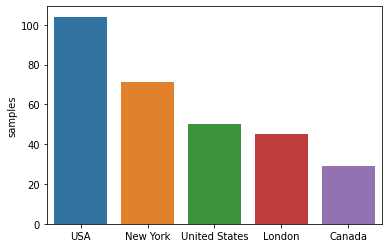

In [0]:
#exlporing top 5 locations 
x = train_df['location'].value_counts()[:5]
plot_bar(x)

Most of the tweets are in the USA. The top 3 location are in the US with different name. Then a few from UK and canada

### Hashtag Analysis

In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non Disaster tweets
Not_Disaster = hashtag_extract(train_df['text'][train_df['target'] == 0])

# extracting hashtags from Disaster tweets
Disaster = hashtag_extract(train_df['text'][train_df['target'] == 1])

# unnesting list
Not_Disaster = sum(Not_Disaster,[])
Disaster = sum(Disaster,[])

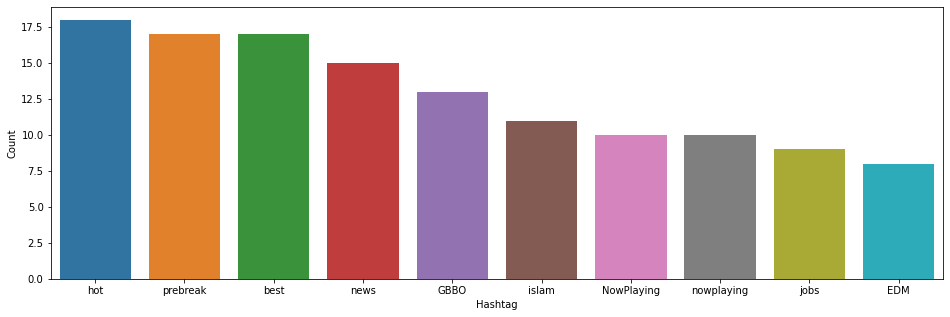

In [0]:
# Fake Disaster tweets
a = nltk.FreqDist(Not_Disaster)
nd = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
nd = nd.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=nd, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

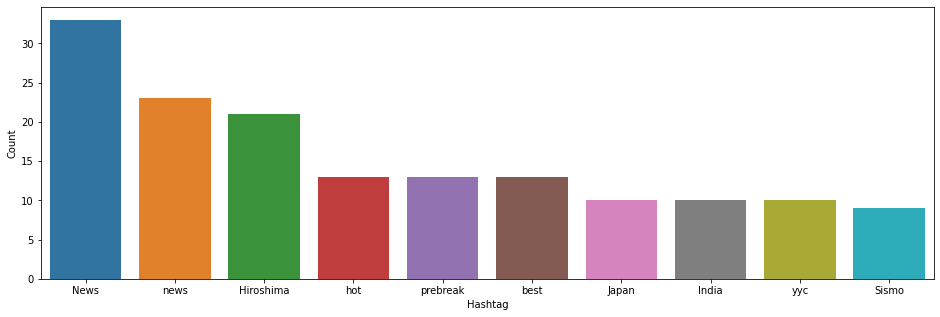

In [0]:
# True Disaster tweets
b = nltk.FreqDist(Disaster)
d = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

While different words can be detected in True diaster tweets, some of the hashtag like hot, best, and news appears in both categories. Therefore, Hashtag will be removed in data cleaning part.

## **Data Cleaning**

*   Making all uppercase to lowercase
*   Removing noise from tweets

  *   URLs
  *   HTML tags
  *   emogis
  *   Punctuation
  *   New-Line
  *   Removing Digits
*   Spell-checker(optional)



In [0]:
#function to remove noise from text
def clean_text(text):
    text = text.lower() #convert to lowercase to maintain standard flow between text
    text = re.sub('\[.*?\]', '', text) #removing text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #removing url
    text = re.sub('<.*?>+', '', text) #removing html tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #removing puntuations
    text = re.sub('\n', '', text)#removing new line from the text field
    text = re.sub('\w*\d\w*', '', text) #removing digits from the string
    return text

train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [0]:
#function to remove emoji's
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df['text']=train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text']=test_df['text'].apply(lambda x: remove_emoji(x))

In [0]:
#adding new column with the count of words in a single row
train_df['word_count'] = train_df['text'].str.split().map(len)

#only using the rows with word count more than 0
train_df = train_df[train_df['word_count'] > 0]

#moving forward with 2 column from dataset , i.e., text and target
train_df = train_df[["text","target"]]
test_df = test_df[["text"]]

In [0]:
pip install pyspellchecker

In [0]:
# optional remove ''' ''' to run spell checker
'''
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

train_df['text']=train_df['text'].apply(lambda x: correct_spellings(x))
test_df['text']=test_df['text'].apply(lambda x: correct_spellings(x))
        
'''

'\nfrom spellchecker import SpellChecker\nspell = SpellChecker()\ndef correct_spellings(text):\n    corrected_text = []\n    misspelled_words = spell.unknown(text.split())\n    for word in text.split():\n        if word in misspelled_words:\n            corrected_text.append(spell.correction(word))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text)\n\ntrain_df[\'text\']=train_df[\'text\'].apply(lambda x: correct_spellings(x))\ntest_df[\'text\']=test_df[\'text\'].apply(lambda x: correct_spellings(x))\n        \n'

In [0]:
#adding new column with the count of words in a single row
train_df['word_count'] = train_df['text'].str.split().map(len)

#only using the rows with word count more than 0
train_df = train_df[train_df['word_count'] > 0]

#moving forward with 2 column from dataset , i.e., text and target
train_df = train_df[["text","target"]]
test_df = test_df[["text"]]

## **Data Preprocessing**

### Vectorized

Text data is coded with strings and is not an appropriate input format in modelling. We want each unique word to be represented by integer and each tweet is represented by a vector of integer that can be mapped to a particular word.

In [0]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [0]:
# Split train dataset for cross validation and create token
training_sentences = [ i for i in train_df.text[:6000]]
test_sentences = [i for i in train_df.text[6000:]]

training_labels = [ i for i in train_df.target[:6000]]
test_labels = [i for i in train_df.target[6000:]]

tokenizer = Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print('Number of unique words:',len(word_index))

# Encode sentences 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Padding
training_padded = pad_sequences(training_sequences,padding='post', maxlen = 100, truncating='post')
test_padded = pad_sequences(test_sequences,padding='post', maxlen = 100, truncating='post')

X_train = np.array(training_padded)
y_train = np.array(training_labels)

X_test = np.array(test_padded)
y_test = np.array(test_labels)

Number of unique words: 14315


There are 14315 unique words in our dataset.

In [0]:
print('Xtrain size:', X_train.shape)
print('ytrain size:', y_train.shape)
print('Xtest size:', X_test.shape)
print('ytest size:', y_test.shape)

Xtrain size: (6000, 100)
ytrain size: (6000,)
Xtest size: (1612, 100)
ytest size: (1612,)


### Word Embedding
This is a representation of text where similar words have a similar representation. In this project we will use two models of word embedding which are the one from keras layer and GloVe from standford. We will later compare which model is better for our dataset. Or if there are indifferent. This is also a good way to study how different embedding effects model performance



#### **Keras Embedding Layer**
The layer initialized random weights and learn the embedding for all words in the dataset. The layer will be directly create when we create model. 

In [0]:
embedded_keras = tf.keras.layers.Embedding(len(word_index), 16)

#### **GloVe Embedding Layer**

GloVe or Global Vectors for Word Representation is a pretrained model which is an extension of word2vec. It creates a measure to indicate which words are more likely to appear in context of others. People have used GloVe with the reason that they believe it generalizes with the data and it contains a larger vocabulary set. The pretained GloVe can be downloaded from https://nlp.stanford.edu/projects/glove/

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load the whole embedding into memory
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# 100 dimensional version (embedding dimension)
embeddings_index = dict()
f = open('/content/drive/My Drive/Colab Notebooks/glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Embedding Matrix

In [0]:
embedding_matrix = np.zeros((len(word_index)+1, 100))

# Fill the weight in
for word, i in tokenizer.word_index.items():
    embedding_vec = embeddings_index.get(word)
    if embedding_vec is not None:
        #add to the matrix
        embedding_matrix[i] = embedding_vec

Embedding Layer

In [0]:
embedded = tf.keras.layers.Embedding(input_dim= len(word_index)+1, output_dim=100,
                                    weights = [embedding_matrix], input_length=X_train.shape[1], trainable = False)

## **Linear Model**
We presume that linear model is probably inappropriate for this dataset, however for out experiment, we would like to see how the data is explained by linear model.

In [0]:
log_X = vectorize_sequences(training_sequences,dimension=len(word_index))
log_y = np.asarray(training_labels).astype('float32')
logreg = LogisticRegression()
logreg_scores = cross_validate(logreg, log_X, log_y, cv=5, scoring="f1", n_jobs=-1, return_train_score=True)
logreg_scores

{'fit_time': array([14.7415998 , 16.59960866, 15.05082655, 13.83539367,  8.68329477]),
 'score_time': array([0.04654741, 0.04602957, 0.04626012, 0.05308867, 0.0257225 ]),
 'test_score': array([0.63461538, 0.52548131, 0.57266811, 0.6       , 0.63255814]),
 'train_score': array([0.93604951, 0.93555841, 0.93666323, 0.94374518, 0.93978991])}

In [0]:
logreg_scores['test_score'].mean()

0.5930645901303635

## **Recurrent Neural Network**

![Neural Network](https://drive.google.com/uc?id=1cBwZQMdIg9ybwr6D_VGbKaMsHIFBqGmS)

**Why RNN? Why does not a simple neural network fit for this data?**

* Inputs, outputs can be of different lengths in different examples
* Doesn't share features learned across different position of text

To overcome this we use Recurrent Neural Network, as it scans words from left to right, one drawback is that it only knows features from its left. Unlike feedforward network, RNN creates loops between each node in the neural network. It remembers the past or whatever it has learnt from prior input. This means it is able to learn the sequences of the data and generate a state that has information about what it has seen.


### **Model 1: Vanilla RNN (RNN from Scratch) - Word Level**

![alt text](https://drive.google.com/uc?id=1GASStj6K7826BPUBs0b_0aTR8nWD4PFX)

The idea is to create a word level RNN in python/numpy that will provide a baseline model for more complex Neural Networks architecture, and also to gain low level understanding of the working of RNN (Sequence model)

*Credits:*

Andrej Karpathy https://gist.github.com/karpathy/d4dee566867f8291f086: Minimal character-level language model with a Vanilla Recurrent Neural Network, in Python/numpy. And the blog http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

The deep learning book by Michael Nielsen particularly http://neuralnetworksanddeeplearning.com/chap6.html

Andrew ng Deep learning course (Course 5) on Coursera

**Steps Taken:**

1. Creating a vocabulary list of unique words from data to be later used in encoding each words into a one-hot vector using 1-k encoding. (k = len(vocab_list)
2. Initialize the RNN model parameters
3. Feedforward the training data(tweets) vectorized form into the network and calculate loss for that training example
4. Backpropagate through time and obtain the gradient parameters.
5. Gradient clipping to avoid exploding gradient problem
6. Select/iterating over different learning rate and calculating new model paramters
7. Repeating steps from 3-6 for some number of iterations that covers all training examples atleast 3 times

In [0]:
#creating vocabulary list which will have uniqe word list from training data
vocab_list = list(train_df['text'].str.split(' ',expand=True).stack().unique())
total_words = list(train_df['text'].str.split(' ',expand=True).stack())

vocab_list_size = len(vocab_list)
total_words_len = len(total_words)

print("Vocab size : ",vocab_list_size)
print("Total words in data : ", total_words_len)

#creating a dictionary that has an index for each of the unique words
words_idx = { word:i for i, word in enumerate(vocab_list) }

Vocab size :  16834
Total words in data :  113521


In [0]:
#converting a single training sample to retreive from dictionary
temp = train_df['text'].str.split().values[1]
inputs = [words_idx[i] for i in temp]
output = train_df['target'].values[1]
print("original text:",temp)
print("Wordlist index:",inputs)
print("Target label:",output)

original text: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
Wordlist index: [13, 14, 15, 16, 17, 18, 19]
Target label: 1


In [0]:
#hyperparameters
learning_rate = 0.005
n_a = hidden_size = 100
n_x = vocab_list_size 
n_y = 2

#model_parameters
Waa = np.random.randn(hidden_size,hidden_size)*0.1
Wax = np.random.randn(hidden_size,vocab_list_size)*0.1
Wya = np.random.randn(2,hidden_size)*0.1
ba = np.zeros((n_a,1))
by = np.zeros((n_y,1))

#spliting into training and validation
temp_df = train_df
train = train_df.iloc[:7000]
validation = temp_df.iloc[7000:]

print('The training set examples: %d' %(len(train)))
print('The validation set examples: %d' %(len(validation)))


The training set examples: 7000
The validation set examples: 612


In [0]:
#activation function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

![alt text](https://drive.google.com/uc?id=1MwD3M4EhqytzU0r_OJnNYxVDDi7d7obJ)

In [0]:
#feed-forward -- takes in the index of words in a example tweet and return the prediction
def rnn_feedforward(input_data):
  #initializing
  xt,at = [], np.zeros((n_a,1))
  for t in range(len(input_data)):
    xt.append(np.zeros((n_x,1)))#encode in 1-k one hot-representation
    xt[t][input_data[t]] = 1
    at = np.tanh(np.dot(Waa,at)+np.dot(Wax,xt[t])+ba) #hidden state activation function
    
  yt = np.dot(Wya,at) + by 
  pred = softmax(yt) #softmax function for getting probability for binary classification
  prediction = np.argmax(pred)
  return prediction

In [0]:
num_iterations = 5

#memory variables for Adagrad
mWaa, mWya, mWax = np.zeros_like(Waa), np.zeros_like(Wya), np.zeros_like(Wax)
mby, mba = np.zeros_like(by), np.zeros_like(ba)

for i in range(num_iterations):
  
  idx = i%len(train)
  example = train['text'].str.split().values[idx]
  inputs = [words_idx[i] for i in example]
  print(inputs)
  targets = int(train['target'].values[idx])
  
  prediction = rnn_feedforward(inputs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[13, 14, 15, 16, 17, 18, 19]
[12, 20, 21, 22, 23, 24, 25, 2, 26, 27, 28, 29, 30, 31, 32, 33, 23, 24, 25, 34, 2, 35]
[37, 38, 39, 32, 34, 24, 40]
[41, 42, 43, 6, 44, 45, 46, 47, 48, 49, 45, 39, 50, 51, 52, 53]


Function that takes input as one row with text and target value, feedforward the network, calculates the cost which is loss of predicted vs actual Y/target.

Then performs backpropagation and updates the gradient of all the parameters and returns it.

![alt text](https://drive.google.com/uc?id=1LxlNKbu037x2KrAoz5DMKf_BLLEprnTA)

In [0]:
#feedforward and backpropagation
def rnn_model(input_data,targets):
  
  xt,at = [],[]
  at.append(np.zeros((n_a,1)))
  loss = 0
  
  #feed forward
  for t in range(len(input_data)):
    xt.append(np.zeros((n_x,1)))
    xt[t][input_data[t]] = 1
    
    at.append(np.tanh(np.dot(Waa,at[t])+np.dot(Wax,xt[t])+ba))
    
  yt = np.dot(Wya,at[-1]) + by
  pred = np.exp(yt) / np.sum(np.exp(yt),axis=0)
  
  prediction = np.argmax(pred)
  
  #loss-cost
  
  y = np.zeros((2,1))
  y[targets] = 1
  loss = -np.log(np.sum(pred*y,axis = 0)) #cross-entropy loss
  
  #backpropagation through time
  dWaa, dWya, dWax = np.zeros_like(Waa), np.zeros_like(Wya), np.zeros_like(Wax)
  dby, dba = np.zeros_like(by), np.zeros_like(ba)
  
  dy = pred - y
  dWya = np.dot(dy,at[-1].transpose())
  dby = np.copy(dy)
  
  dat = np.dot(Wya.transpose(),dy)
  dtanh = (1-at[-1]*at[-1]) * dat
  
  dWax = np.dot(dtanh, xt[-1].transpose())
  dWaa = np.dot(dtanh, at[-2].transpose())
  dba = np.copy(dtanh)
  da_next = np.dot(Waa.transpose(),dtanh)
  for t in reversed(range(len(input_data)-2)):
    
    dat = np.copy(da_next)
    dtanh = (1- at[t+1] * at[t+1]) * dat
    
    dWax += np.dot(dtanh, xt[t].transpose())
    dWaa += np.dot(dtanh, at[t].transpose())
    dba += np.copy(dtanh)
    da_next = np.dot(Waa.transpose(),dtanh)
    
  for dparams in [dWaa,dWax,dba,dby,dWya]:
    np.clip(dparams,-5,5,out=dparams)
    
  return loss, dWaa, dWax, dba, dby, dWya

Feeding training data into the network to retrieve the gradient and using Adagrad optimizer to perform the gradient descent. 

And we repeat this process for all the training examples and for n epochs

**Adagrad Optimizer** : Adaptively scales the learning rate with respect to the accumulated square gradient at each iteration in each dimention

In [0]:
#select any number of iteration for start
num_iterations = 15000
test_scores = []
#memory variables for Adagrad optimizer - backprop
mWaa, mWya, mWax = np.zeros_like(Waa), np.zeros_like(Wya), np.zeros_like(Wax)
mby, mba = np.zeros_like(by), np.zeros_like(ba)

for i in range(num_iterations):
  idx = i%len(train)
  example = train['text'].str.split().values[idx]
  inputs = [words_idx[i] for i in example]
  targets = int(train['target'].values[idx])
  
  #prediction = rnn_feedforward(inputs,targets)
  loss,dWaa, dWax, dba, dby, dWya = rnn_model(inputs,targets)
  
  #Adagrad optimizer
  #performing paramete update with Adagrad
  for param, dparam, mem in zip([Waa, Wax, Wya, ba, by],
                                [dWaa, dWax, dWya, dba, dby],
                                [mWaa, mWax, mWya, mba, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem+1e-8) #adagrad update
  
  # validation accuracy
  # using for loop instead of vectorization
  if i % 700 == 0:
    predictions = []
    count=0
    actual_targets= validation['target'].tolist()
    for j in range(len(validation)):
        example = validation['text'].str.split().values[j]
        inputs = [words_idx[l] for l in example]
        predictions.append(rnn_feedforward(inputs))
          
    for y, y_hat in zip(actual_targets, predictions):
        if y==y_hat:
            count+=1
    print('The validation_accuracy after iterations:%d is %d'%(i,(count/len(validation))*100))
    test_scores.append((count/len(validation))*100)

The validation_accuracy after iterations:0 is 54
The validation_accuracy after iterations:700 is 47
The validation_accuracy after iterations:1400 is 55
The validation_accuracy after iterations:2100 is 47
The validation_accuracy after iterations:2800 is 54
The validation_accuracy after iterations:3500 is 59
The validation_accuracy after iterations:4200 is 59
The validation_accuracy after iterations:4900 is 64
The validation_accuracy after iterations:5600 is 66
The validation_accuracy after iterations:6300 is 63
The validation_accuracy after iterations:7000 is 65
The validation_accuracy after iterations:7700 is 62
The validation_accuracy after iterations:8400 is 67
The validation_accuracy after iterations:9100 is 69
The validation_accuracy after iterations:9800 is 71
The validation_accuracy after iterations:10500 is 71
The validation_accuracy after iterations:11200 is 72
The validation_accuracy after iterations:11900 is 70
The validation_accuracy after iterations:12600 is 71
The validati

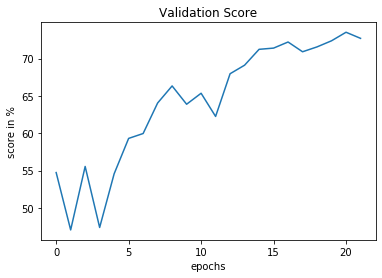

In [0]:
plt.plot(test_scores)
plt.xlabel("epochs")
plt.ylabel("score in %")
plt.title("Validation Score")
plt.show()

**Results Summary:**

The validation accuracy arrives closely to 72% (better than randomly guessing). Tried 2 sets of learning rate values with 0.001 accuracy was 70% whereas with learning rate 0.005 accuracy boosted to 72%. 

We have not experimented with other hyperparameters or tried any high level/complex data cleaning. Still, it seems that my RNN is learning association between words that helps to classify the tweets.

**Future scope:**
we can try different network architectures 
training model for longer iterations

In [0]:
#saving matrix values for parameters which includes weights and biases for later use to predict test data
# saving the model
import pickle
filename = 'rnn_model_v1.pkl'
with open(filename, "wb") as f:
    pickle.dump((Waa, Wax, ba, by, Wya ), f)

In [0]:
#loading the saved model
import pickle
filename = 'rnn_model_v1.pkl'
with open(filename, "rb") as f:
    Waa, Wax, ba, by, Wya  = pickle.load(f)

In [0]:
#checking if parameters loaded in correctly
#using loaded model
count = 0
for j in range(len(validation)):
  
  example = validation['text'].str.split().values[j]
  inputs = [words_idx[l] for l in example]
  predictions.append(rnn_feedforward(inputs))
          
for y, y_hat in zip(actual_targets, predictions):
  if y==y_hat:
    count+=1
print("Correctly Predicted:",count)
print("Total Data in validation set:",len(validation))
print('The validation_accuracy is',(count/len(validation))*100)

Correctly Predicted: 445
Total Data in validation set: 612
The validation_accuracy is 72.7124183006536


### Model 2: LSTM model with regularization, increase dimensionality

In [0]:
lstm_m1 = tf.keras.models.Sequential([
    embedded,
    tf.keras.layers.LSTM(256, dropout=0.2, recurrent_dropout=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_m1.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
lstm_m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1431600   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 1,797,425
Trainable params: 365,825
Non-trainable params: 1,431,600
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'):
  hist_m1 = lstm_m1.fit(X_train, y_train, epochs = 20, batch_size = 256, validation_data= (X_test, y_test))

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 [==============================] - 11s 2ms/sample - loss: 0.6906 - accuracy: 0.5768 - val_loss: 0.6922 - val_accuracy: 0.5323
Epoch 2/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6808 - accuracy: 0.5805 - val_loss: 0.6927 - val_accuracy: 0.5323
Epoch 3/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6812 - accuracy: 0.5805 - val_loss: 0.6932 - val_accuracy: 0.5323
Epoch 4/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6632 - accuracy: 0.6090 - val_loss: 0.5803 - val_accuracy: 0.7016
Epoch 5/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6020 - accuracy: 0.6948 - val_loss: 0.5510 - val_accuracy: 0.7543
Epoch 6/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6118 - accuracy: 0.6420 - val_loss: 0.5901 - val_accuracy: 0.7295
Epoch 7/20
6000/6000 [==============================] - 7s 1ms/sample - los

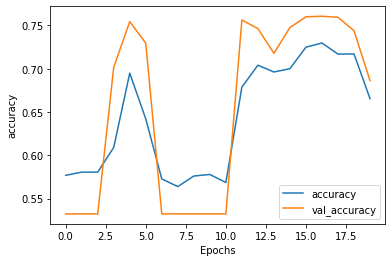

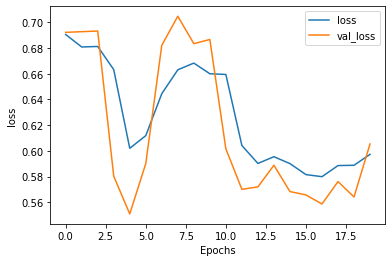

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string , 'val_'+string])
  plt.show()
  
plot_graphs(hist_m1, "accuracy")
plot_graphs(hist_m1, "loss")

In [0]:
# Find train and test accuracy
loss, accuracy = lstm_m1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_m1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6570
Testing Accuracy:  0.6861


### Model 3: LSTM with regularization, reduce dimensionality

In [0]:
lstm_m2 = tf.keras.models.Sequential([
    embedded,
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_m2.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
lstm_m2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1431600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,473,905
Trainable params: 42,305
Non-trainable params: 1,431,600
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'):
  hist_m2 = lstm_m2.fit(X_train, y_train, epochs = 20, batch_size = 256, validation_data= (X_test, y_test))

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 [==============================] - 10s 2ms/sample - loss: 0.6836 - accuracy: 0.5777 - val_loss: 0.6944 - val_accuracy: 0.5323
Epoch 2/20
6000/6000 [==============================] - 6s 1ms/sample - loss: 0.6565 - accuracy: 0.6253 - val_loss: 0.5600 - val_accuracy: 0.7785
Epoch 3/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6183 - accuracy: 0.6833 - val_loss: 0.5450 - val_accuracy: 0.7723
Epoch 4/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6011 - accuracy: 0.7092 - val_loss: 0.5566 - val_accuracy: 0.7655
Epoch 5/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6018 - accuracy: 0.6928 - val_loss: 0.5638 - val_accuracy: 0.7661
Epoch 6/20
6000/6000 [==============================] - 6s 1ms/sample - loss: 0.5888 - accuracy: 0.7073 - val_loss: 0.5590 - val_accuracy: 0.7692
Epoch 7/20
6000/6000 [==============================] - 7s 1ms/sample - los

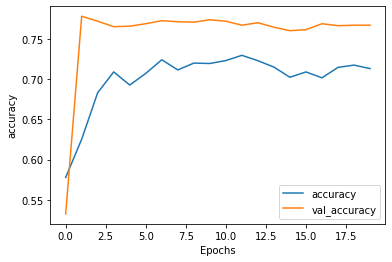

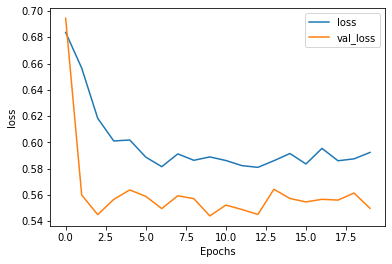

In [0]:
plot_graphs(hist_m2, "accuracy")
plot_graphs(hist_m2, "loss")

In [0]:
# Find train and test accuracy
loss, accuracy = lstm_m2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_m2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7428
Testing Accuracy:  0.7674


### Model 4: LSTM Layer Stacking 

In [0]:
lstm_m3 = tf.keras.models.Sequential([
    embedded,
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.5, return_sequences = True),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_m3.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
lstm_m3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1431600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,598,321
Trainable params: 166,721
Non-trainable params: 1,431,600
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'):
  hist_m3 = lstm_m3.fit(X_train, y_train, epochs = 20, batch_size = 256, validation_data= (X_test, y_test))

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 [==============================] - 18s 3ms/sample - loss: 0.6836 - accuracy: 0.5757 - val_loss: 0.6939 - val_accuracy: 0.5323
Epoch 2/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.6810 - accuracy: 0.5803 - val_loss: 0.6921 - val_accuracy: 0.5323
Epoch 3/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.6156 - accuracy: 0.6898 - val_loss: 0.5515 - val_accuracy: 0.7612
Epoch 4/20
6000/6000 [==============================] - 12s 2ms/sample - loss: 0.5960 - accuracy: 0.6925 - val_loss: 0.5537 - val_accuracy: 0.7562
Epoch 5/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5948 - accuracy: 0.6920 - val_loss: 0.5554 - val_accuracy: 0.7705
Epoch 6/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5950 - accuracy: 0.7173 - val_loss: 0.5426 - val_accuracy: 0.7686
Epoch 7/20
6000/6000 [==============================] - 12s 2ms/sample

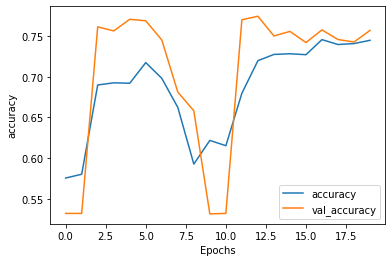

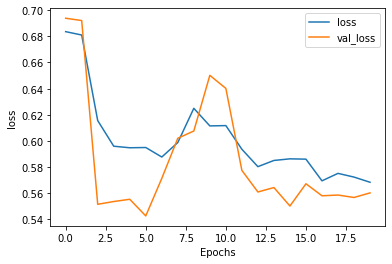

In [0]:
plot_graphs(hist_m3, "accuracy")
plot_graphs(hist_m3, "loss")

In [0]:
# Find train and test accuracy
loss, accuracy = lstm_m3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_m3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7563
Testing Accuracy:  0.7568


### Model 5: LSTM with SpatialDropout

In [0]:
lstm_m5 = tf.keras.models.Sequential([
    embedded,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_m5.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])

In [0]:
lstm_m5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1431600   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 1,473,905
Trainable params: 42,305
Non-trainable params: 1,431,600
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'):
  hist_m5 = lstm_m5.fit(X_train, y_train , batch_size=256, epochs=20,validation_data=(X_test, y_test))

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 [==============================] - 10s 2ms/sample - loss: 0.6842 - accuracy: 0.5773 - val_loss: 0.6974 - val_accuracy: 0.5323
Epoch 2/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6810 - accuracy: 0.5805 - val_loss: 0.6962 - val_accuracy: 0.5323
Epoch 3/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6184 - accuracy: 0.6607 - val_loss: 0.5473 - val_accuracy: 0.7730
Epoch 4/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.5775 - accuracy: 0.7270 - val_loss: 0.5459 - val_accuracy: 0.7568
Epoch 5/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.5895 - accuracy: 0.6940 - val_loss: 0.5971 - val_accuracy: 0.6731
Epoch 6/20
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.6015 - accuracy: 0.6673 - val_loss: 0.5664 - val_accuracy: 0.7767
Epoch 7/20
6000/6000 [==============================] - 6s 1ms/sample - los

In [0]:
# Find train and test accuracy
loss, accuracy = lstm_m5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_m5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7607
Testing Accuracy:  0.7699


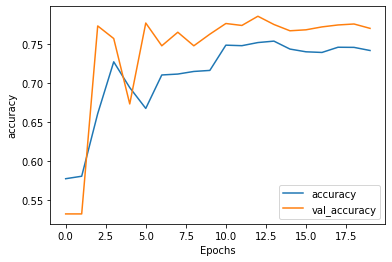

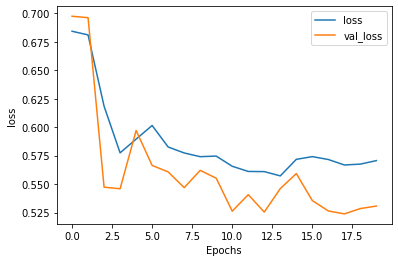

In [0]:
plot_graphs(hist_m5, "accuracy")
plot_graphs(hist_m5, "loss")

### Model 6: Bidirectional RNN

In [0]:
bi_m6 = tf.keras.models.Sequential([
                                    embedded,
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.5)),
                                    tf.keras.layers.Dense(1)
])

bi_m6.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
bi_m6.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1431600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,516,209
Trainable params: 84,609
Non-trainable params: 1,431,600
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'):
  hist_m6 = bi_m6.fit(X_train, y_train , batch_size=256, epochs=20,validation_data=(X_test, y_test))

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 [==============================] - 19s 3ms/sample - loss: 0.7502 - accuracy: 0.6752 - val_loss: 0.5356 - val_accuracy: 0.7239
Epoch 2/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5879 - accuracy: 0.7410 - val_loss: 0.5133 - val_accuracy: 0.7593
Epoch 3/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5424 - accuracy: 0.7582 - val_loss: 0.4945 - val_accuracy: 0.7823
Epoch 4/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5459 - accuracy: 0.7647 - val_loss: 0.4828 - val_accuracy: 0.7804
Epoch 5/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5276 - accuracy: 0.7725 - val_loss: 0.4742 - val_accuracy: 0.7872
Epoch 6/20
6000/6000 [==============================] - 13s 2ms/sample - loss: 0.5145 - accuracy: 0.7792 - val_loss: 0.4937 - val_accuracy: 0.7785
Epoch 7/20
6000/6000 [==============================] - 13s 2ms/sample

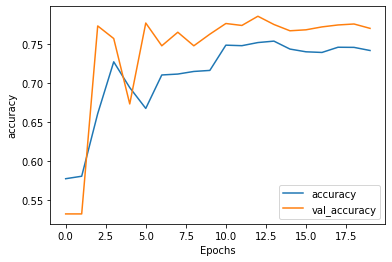

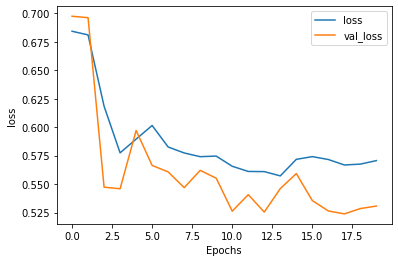

In [0]:
plot_graphs(hist_m5, "accuracy")
plot_graphs(hist_m5, "loss")

In [0]:
# Find train and test accuracy
loss, accuracy = bi_m6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = bi_m6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8228
Testing Accuracy:  0.7971


## Accuracy Comparison

In [0]:
accuracylog = logreg_scores['test_score'].mean()
print("Testing Accuracy:  {:.4f}".format(accuracylog))

Vanilla_acc = (count/len(validation))

loss, accuracym1 = lstm_m1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracym0))

loss, accuracym2 = lstm_m2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracym1))

loss, accuracym3 = lstm_m3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracym2))

loss, accuracym4 = lstm_m4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracym3))

loss, accuracym5 = lstm_m5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracym4))

loss, accuracym6 = bi_m6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracym4))

Testing Accuracy:  0.5931
ERROR! Session/line number was not unique in database. History logging moved to new session 62


NameError: ignored

In [0]:
acc = [accuracylog,accuracym0,accuracym1,accuracym2,accuracym3,accuracym4]
Methods = ['Logistic', 'Vanila', 'LSTM1','LSTM2','LSTM3','LSTM4','LSTM5','BIDIRECT']
Accuracy_pos = np.arange(len(Methods))

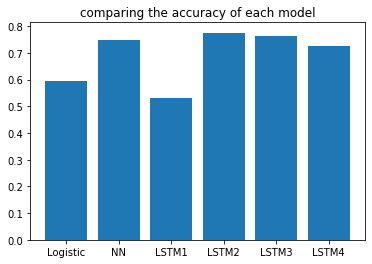

In [0]:
plt.bar(Accuracy_pos, acc)
plt.xticks(Accuracy_pos, Methods)
plt.title('comparing the accuracy of each model')
plt.show()

LSTM2 (reduce dimensionality) seems to work better than the rest, therefore we will keep working on LSTM model.